#**Pré-processamento**

In [23]:
from google.colab import drive 
drive.mount('/content/gdrive')

import pandas as pd
import seaborn as sns
import missingno as msno
import warnings
from matplotlib import pyplot as plt
import datetime
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',100)

df = pd.read_csv("gdrive/My Drive/dissertação/Qualidade_do_ar_-_Dados_horarios.csv",sep=",")
df['Data']=df['Data'].astype('str')
df['Data']=df['Data'].apply(lambda x: x[:-3])

#conversão para datetime
def convert_to_datetime(x):
    return(datetime.datetime.strptime(x, "%Y/%m/%d %H:%M:%S"))
df['Data']=df['Data'].apply(convert_to_datetime) 
df['Hora-minuto']=df['Data'].apply(lambda x: str(x)[-8:-3])
# #extrair ano, mes, hora 
df['Ano']=df['Data'].apply(lambda x: x.year)
df['Mês']=df['Data'].apply(lambda x: x.month)
df['Dia']=df['Data'].apply(lambda x: x.day)
df['Hora']=df['Data'].apply(lambda x: x.hour)
df['Hora-minuto']=df['Data'].apply(lambda x: str(x)[-11:-6])

df_bg=df[df['Estação']=='BG'] #Bangu
df_gc=df[df['Estação']=='CG'] #Campo Grande
df_ca=df[df['Estação']=='CA'] #Centro
df_av=df[df['Estação']=='AV'] #Copacabana
df_ir=df[df['Estação']=='IR'] #Irajá
df_pg=df[df['Estação']=='PG'] #Pedra de Guaratiba
df_sc=df[df['Estação']=='SC'] #São Cristóvão
df_sp=df[df['Estação']=='SP'] #Tijuca

df_sc.set_index('Data',inplace=True)
df_sc.drop(columns=['OBJECTID','CodNum','Estação','Dir_Vento','NO2','HCNM','HCT','CH4','NO','NOx',\
                   'PM2_5', 'Lat', 'Lon', 'X_UTM_Sirgas2000','Y_UTM_Sirgas2000'], inplace=True)
df_sc_2=df_sc.copy() #para fazer distribuição sem eliminar ausentes

df_sc=df_sc['2011-01-01':'2018-01-01']
#explicar que usou interpolação linear com spline e justificar
df_sc['Chuva'].interpolate(method='slinear', inplace=True)
df_sc['Pres'].interpolate(method='slinear', inplace=True)
df_sc['RS'].interpolate(method='slinear', inplace=True)
df_sc['Temp'].interpolate(method='slinear', inplace=True)
df_sc['UR'].interpolate(method='slinear', inplace=True)
df_sc['Vel_Vento'].interpolate(method='slinear', inplace=True)
df_sc['SO2'].interpolate(method='slinear', inplace=True)
df_sc['CO'].interpolate(method='slinear', inplace=True)
df_sc['O3'].interpolate(method='slinear', inplace=True)
df_sc['PM10'].interpolate(method='slinear', inplace=True)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


#**geração do modelo**

Não esquecer de trocar o LAG

In [24]:
# prepare data for lstm
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score #colocar citação

from math import sqrt
from numpy import concatenate
from matplotlib import pyplot

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.optimizers import Adam

df_sc.drop(columns=['Ano','Mês','Dia','Hora','Hora-minuto'], inplace=True)
#df_sc.drop(columns=['Hora-minuto'], inplace=True)
df_sc_copy=df_sc.copy()
df_sc_copy=df_sc_copy[['O3']]
df_sc.drop(columns=['O3'],inplace=True)
df_sc = pd.concat([df_sc_copy,df_sc], axis=1, ignore_index=False)

values = df_sc.values
# ensure all data is float
values = values.astype('float32')
# normalize features

# scaler = MinMaxScaler(feature_range=(0, 1))
# scaled = scaler.fit_transform(values)

scaled=values #não normalizado

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# specify the number of lag hours
n_hours = 4 #aqui definimos o LAg
n_features = 10

# frame as supervised learning
# reframed = series_to_supervised(scaled, n_hours, 1)
reframed = series_to_supervised(scaled, n_hours, 4) #é aqui que definimos a janela de previsão

# split into train and test sets
values = reframed.values
n_train_hours = 1855 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))

# design network
opt = Adam(learning_rate=0.0005)
model = Sequential()
model.add(LSTM(200, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer=opt)

# fit network
history = model.fit(train_X, train_y, epochs=300, batch_size=500, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/300
90/90 - 1s - loss: 19.1940 - val_loss: 18.7390
Epoch 2/300
90/90 - 0s - loss: 17.9009 - val_loss: 17.9322
Epoch 3/300
90/90 - 0s - loss: 17.3654 - val_loss: 17.3791
Epoch 4/300
90/90 - 0s - loss: 16.8824 - val_loss: 16.8982
Epoch 5/300
90/90 - 0s - loss: 16.4431 - val_loss: 16.4539
Epoch 6/300
90/90 - 0s - loss: 16.0557 - val_loss: 16.1077
Epoch 7/300
90/90 - 0s - loss: 15.7516 - val_loss: 15.7941
Epoch 8/300
90/90 - 0s - loss: 15.4495 - val_loss: 15.4938
Epoch 9/300
90/90 - 0s - loss: 15.1863 - val_loss: 15.2339
Epoch 10/300
90/90 - 0s - loss: 14.9503 - val_loss: 15.0498
Epoch 11/300
90/90 - 0s - loss: 14.7618 - val_loss: 14.8563
Epoch 12/300
90/90 - 0s - loss: 14.5656 - val_loss: 14.6734
Epoch 13/300
90/90 - 0s - loss: 14.3843 - val_loss: 14.5153
Epoch 14/300
90/90 - 0s - loss: 14.2405 - val_loss: 14.3765
Epoch 15/300
90/90 - 0s - loss: 14.1013 - val_loss: 14.2513
Epoch 16/300
90/90 - 0s - loss: 14.0023 - val_loss: 14.1767
Epoch 17/300
90/90 - 0s - loss: 13.8698 - val_los

In [25]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))

# invert scaling for forecast (não foi feito)
inv_yhat = concatenate((yhat, test_X[:, -9:]), axis=1)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -9:]), axis=1)
# inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 16.720


In [26]:
# calculate MAE
mae = mean_absolute_error(inv_y, inv_yhat)
print('Test MAE: %.3f' % mae)

Test MAE: 11.329


In [27]:
# calculate R2
r2=r2_score(inv_y, inv_yhat)
print('Test R2: %.3f' % r2)

Test R2: 0.511


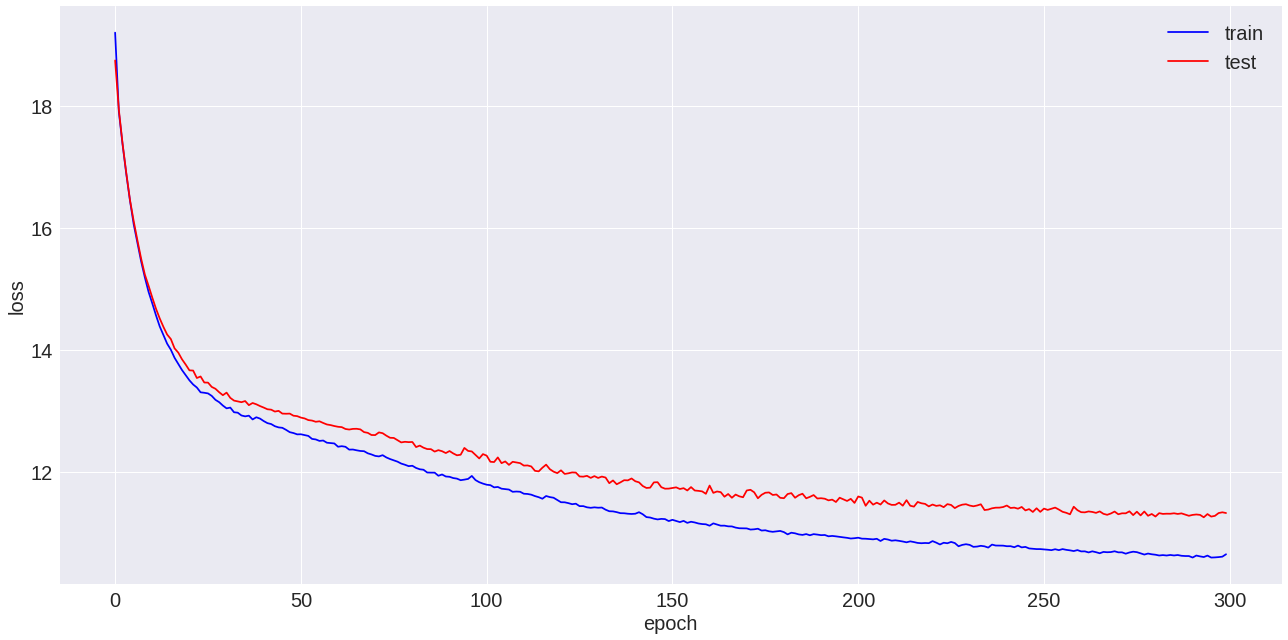

In [28]:
# plot history
plt.style.use('seaborn')
plt.figure(figsize=(18,9))
pyplot.plot(history.history['loss'], label='train', color='blue')
pyplot.plot(history.history['val_loss'], label='test', color='red')
plt.xlabel('epoch',fontsize=20)
plt.ylabel('loss',fontsize=20) 
# plt.title('train and test loss evolution',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
pyplot.legend(fontsize=20)
pyplot.show()

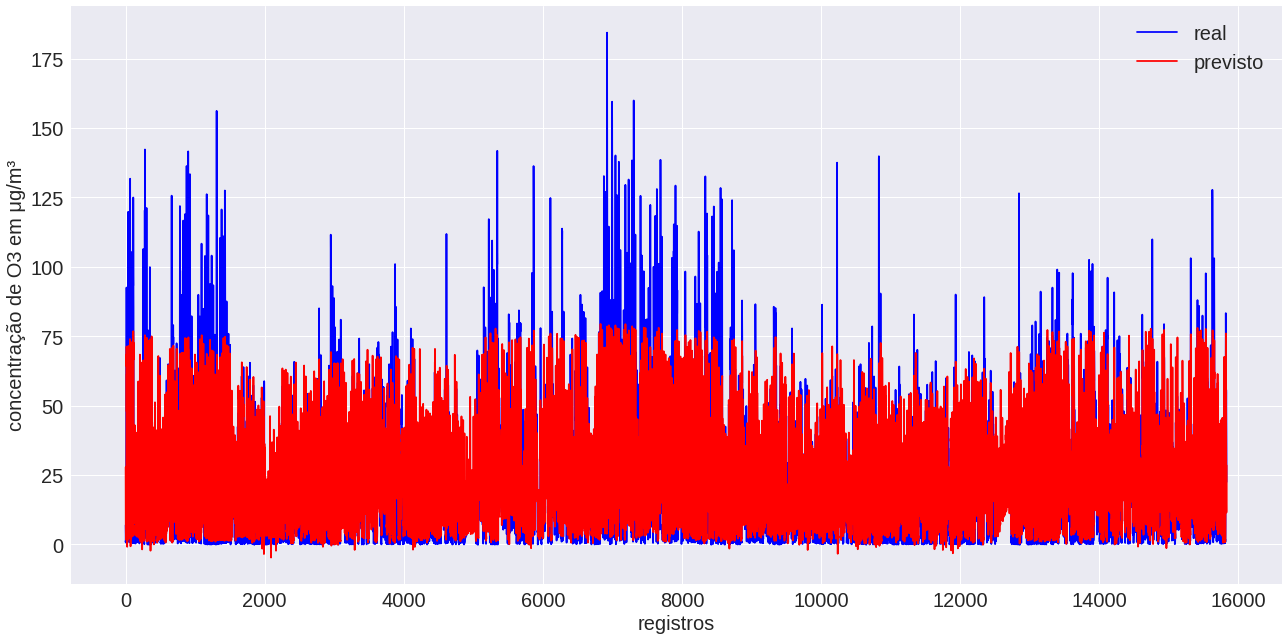

In [29]:
# plot history
plt.style.use('seaborn')
plt.figure(figsize=(18,9))
pyplot.plot(inv_y, label='real', color='blue')
pyplot.plot(inv_yhat, label='previsto', color='red')
plt.xlabel('registros',fontsize=20)
plt.ylabel('concentração de O3 em μg/m³',fontsize=20) 
# plt.title('comparação: real vs previsto',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
pyplot.legend(fontsize=20)
pyplot.show()